Title:
Customer Churn Analysis: Visual Insights and Patterns

Introduction:
In this Jupyter Notebook, I explore a dataset focused on customer churn within a telecommunications company. My objective is to identify key factors that contribute to customer churn, using various visualizations to uncover patterns and insights. By examining demographic information, service usage, and customer satisfaction scores, I aim to provide a comprehensive understanding of the drivers behind customer retention and loss. This analysis serves as a foundation for further predictive modeling and strategic decision-making in customer relationship management.

Data Cleaning:
In this section, I load the dataset and perform essential data-cleaning tasks. I begin by checking for missing values, verifying data types, and identifying any duplicate records. Finally, I generate descriptive statistics to gain insights into the dataset's overall characteristics. This foundational step ensures that the data is prepared for further analysis and visualization.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# loading the dataset
data = pd.read_csv(r'C:\Users\walte\OneDrive\Documents\Work\Customer churn\telco.csv')

# displaying the first few rows of the dataset
print("### preview of the dataset ###")
print(data.head())

# data cleaning process
print("\n### data cleaning overview ###")

# checking for missing values
print("#### missing values ####")
print(data.isnull().sum())

# displaying the data types of each column
print("\n#### data types ####")
print(data.dtypes)

# identifying duplicate records
print("\n#### duplicate records ####")
print(f"total duplicates: {data.duplicated().sum()}")

# getting descriptive statistics of the dataset
print("\n#### descriptive statistics ####")
print(data.describe())

### preview of the dataset ###
  Customer ID  Gender  Age Under 30 Senior Citizen Married Dependents  \
0  8779-QRDMV    Male   78       No            Yes      No         No   
1  7495-OOKFY  Female   74       No            Yes     Yes        Yes   
2  1658-BYGOY    Male   71       No            Yes      No        Yes   
3  4598-XLKNJ  Female   78       No            Yes     Yes        Yes   
4  4846-WHAFZ  Female   80       No            Yes     Yes        Yes   

   Number of Dependents        Country       State  ...  \
0                     0  United States  California  ...   
1                     1  United States  California  ...   
2                     3  United States  California  ...   
3                     1  United States  California  ...   
4                     1  United States  California  ...   

  Total Extra Data Charges  Total Long Distance Charges  Total Revenue  \
0                       20                         0.00          59.65   
1                        0 

Customer Churn:
The below code visualises the Churn proportion.

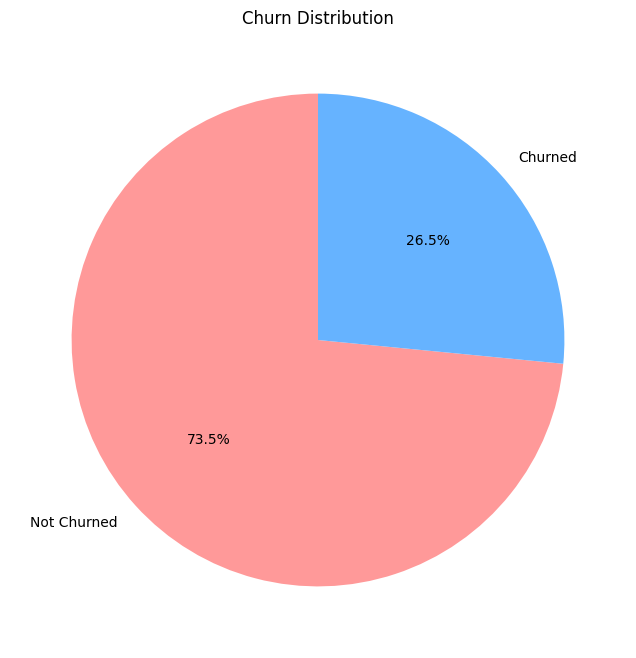

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
from matplotlib.sankey import Sankey
import plotly.graph_objects as go

# loading the dataset
data = pd.read_csv(r'C:\Users\walte\OneDrive\Documents\Work\Customer churn\telco.csv')

#churned vs stayed
plt.figure(figsize=(8, 8))
churn_counts = data['Churn Label'].value_counts()
labels = ['Not Churned', 'Churned']  # Customize labels here
churn_counts.plot.pie(autopct='%1.1f%%', startangle=90, labels=labels, colors=['#ff9999','#66b3ff'])
plt.title('Churn Distribution')
plt.ylabel('')  # Remove the y-label
plt.show()

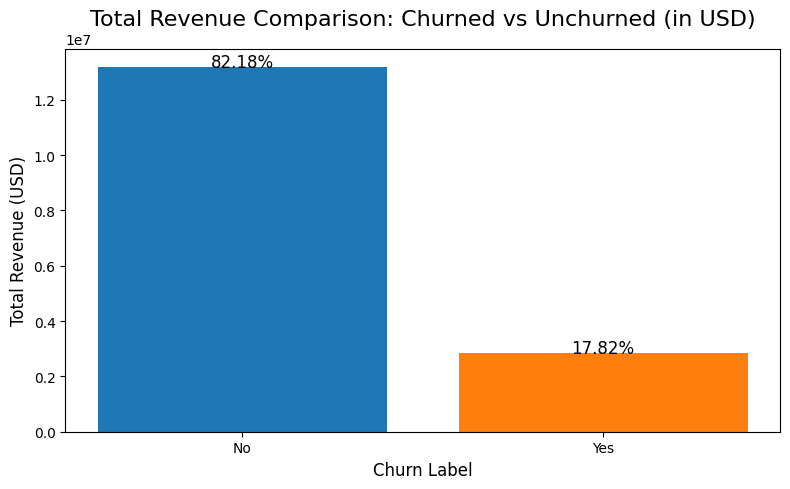

In [11]:
# Calculate total revenue per customer by multiplying Monthly Charges by Tenure
data['Total Revenue'] = data['Monthly Charge'] * data['Tenure in Months']

# Group by Churn Label and calculate the sum of revenue for churned and unchurned customers
revenue_by_churn = data.groupby('Churn Label')['Total Revenue'].sum().reset_index()

# Calculate the percentage contribution of each category to the total revenue
total_revenue = revenue_by_churn['Total Revenue'].sum()
revenue_by_churn['Percentage'] = (revenue_by_churn['Total Revenue'] / total_revenue) * 100

# Plotting the revenue comparison between churned and unchurned customers
plt.figure(figsize=(8, 5))

# Use Matplotlib's bar instead of Seaborn's barplot
colors = ['#1f77b4', '#ff7f0e']  # Custom colors for the bars (you can adjust as needed)
bars = plt.bar(x=revenue_by_churn['Churn Label'], height=revenue_by_churn['Total Revenue'], color=colors)

# Adding labels and title
plt.title('Total Revenue Comparison: Churned vs Unchurned (in USD)', fontsize=16)
plt.xlabel('Churn Label', fontsize=12)
plt.ylabel('Total Revenue (USD)', fontsize=12)

# Adding the percentage above each bar
for i, row in revenue_by_churn.iterrows():
    plt.text(i, row['Total Revenue'] + 1000, f"{row['Percentage']:.2f}%", color='black', ha="center", fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

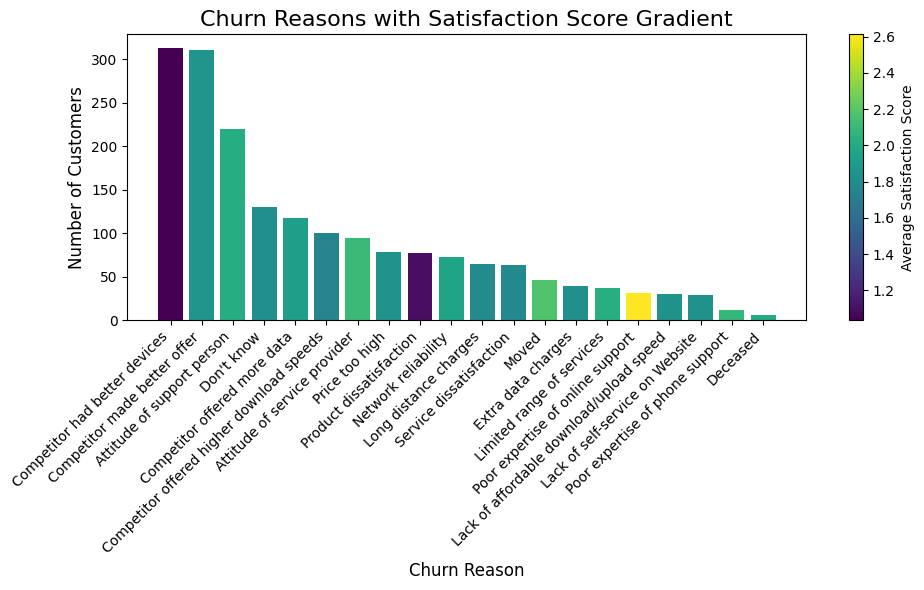

In [8]:
# Ensure satisfaction score and churn reason columns exist in dataset
# Group by Churn Reason and calculate the count and average satisfaction score for each reason
churn_reason_satisfaction = data.groupby('Churn Reason').agg(
    churn_count=('Churn Reason', 'size'),
    avg_satisfaction=('Satisfaction Score', 'mean')
).reset_index()

# Sort by churn count for a cleaner plot
churn_reason_satisfaction = churn_reason_satisfaction.sort_values(by='churn_count', ascending=False)

# Normalize satisfaction scores to use as a color gradient (between 0 and 1)
norm = plt.Normalize(churn_reason_satisfaction['avg_satisfaction'].min(), churn_reason_satisfaction['avg_satisfaction'].max())

# Create a colormap for satisfaction scores
colors = plt.cm.viridis(norm(churn_reason_satisfaction['avg_satisfaction']))

# Plot the Churn Reason bar chart with satisfaction score as color gradient using Matplotlib
plt.figure(figsize=(10, 6))
bars = plt.bar(
    x=churn_reason_satisfaction['Churn Reason'], 
    height=churn_reason_satisfaction['churn_count'], 
    color=colors  # Use the color gradient based on satisfaction
)

# Add color bar to show the gradient meaning
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])

# pass the bar_plot axis when creating the colorbar
plt.colorbar(sm, ax=plt.gca(), label='Average Satisfaction Score')

# Adding labels and title
plt.title('Churn Reasons with Satisfaction Score Gradient', fontsize=16)
plt.xlabel('Churn Reason', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

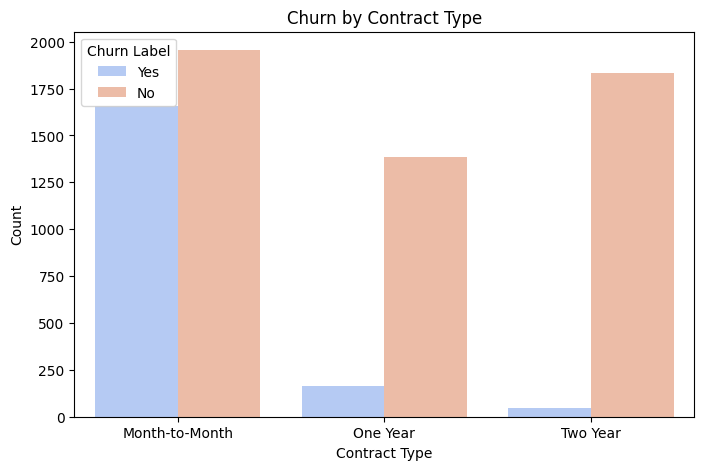

In [10]:
#how does contract type affect churn
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='Contract', hue='Churn Label', palette='coolwarm')
plt.title('Churn by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Count')
plt.legend(title='Churn Label')
plt.show()


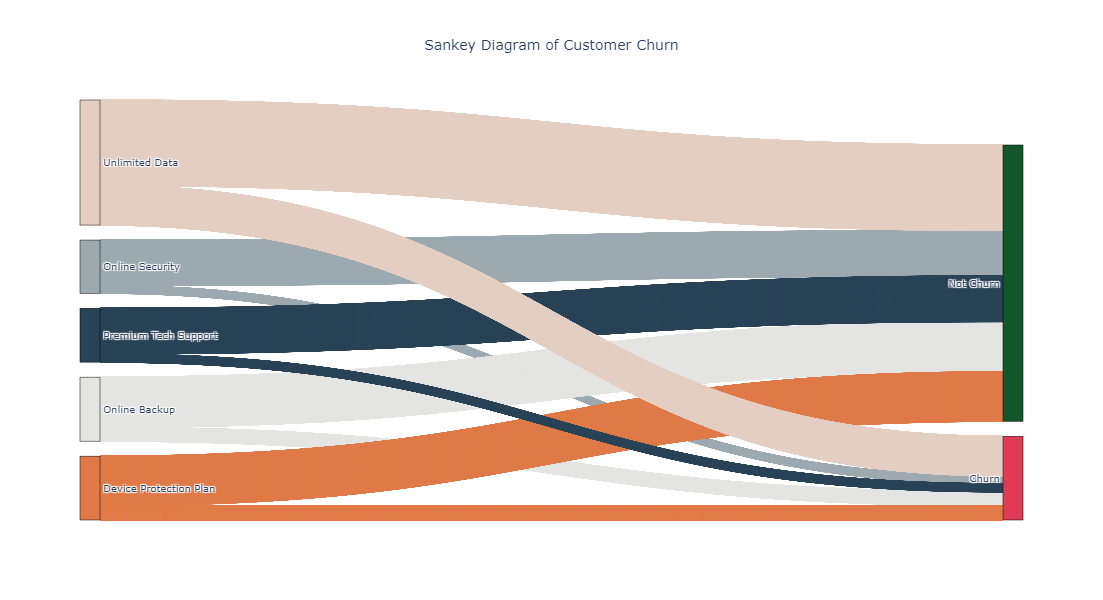

In [13]:
# Define your Sankey diagram function
def sankey(source, target, colorDict, fontsize=12, width=900, height=600, aspect=3):
    # Create label list and assign indices to the unique labels
    all_labels = list(pd.Series(source.tolist() + target.tolist()).unique())
    label_indices = {label: idx for idx, label in enumerate(all_labels)}
    
    # Map the source and target labels to their indices
    source_indices = [label_indices[label] for label in source]
    target_indices = [label_indices[label] for label in target]

    # Define node colors based on labels
    node_colors = [colorDict.get(label, 'grey') for label in all_labels]  # Use 'grey' for any unmatched labels

    # Create the Sankey diagram using Plotly
    fig = go.Figure(go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=all_labels,
            color=node_colors  # Use the colors for the nodes
        ),
        link=dict(
            source=source_indices,  # Map source labels to indices
            target=target_indices,  # Map target labels to indices
            value=[1] * len(source),  # Set a uniform flow value for all
            color=[node_colors[source_indices[i]] for i in range(len(source))]  # Use source node colors for links
        )
    ))

    # Update the layout for better presentation
    fig.update_layout(
        title_text="Sankey Diagram of Customer Churn",
        font_size=fontsize,
        height=height,
        width=width,  # Adjust the width to make sure it fits in the notebook
        autosize=True,  # Allow the diagram to resize automatically
        plot_bgcolor='white',
        title_x=0.5,  # Center the title
        title_xanchor='center'  # Ensure the title is anchored at the center
    )
    
    return fig

# Load the data
additional = pd.read_csv(r'C:\Users\walte\OneDrive\Documents\Work\Customer churn\telco.csv')[['Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Unlimited Data', 'Churn Label']]

# Replace 'Yes' values with their corresponding feature names for labeling
for feature in ['Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Unlimited Data']:
    additional[feature] = additional[feature].replace(to_replace='Yes', value=feature)
    
# Prepare the data for the Sankey diagram
bucket = []
for feature in ['Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Unlimited Data']:
    bucket.append(additional[additional[feature] != 'No'][[feature, 'Churn Label']].rename(columns={feature: 'Label'}))

# Concatenate the filtered data
sankey_data = pd.concat(bucket, axis=0, ignore_index=True)

# Map churn labels to more readable labels
sankey_data['Churn Label'] = sankey_data['Churn Label'].map({'No': 'Not Churn', 'Yes': 'Churn'})

# Define the color palette for the features and churn labels
colorDict = {
    'Online Security': '#9ca9b0',
    'Online Backup': '#e4e4e3',
    'Device Protection Plan': '#df7a48',
    'Premium Tech Support': '#284256',
    'Unlimited Data': '#e4cec1',
    'Churn': '#df3b57',
    'Not Churn': '#12562a'
}

# Create the Sankey diagram and save it as an HTML file
sankey_fig = sankey(sankey_data['Label'], sankey_data['Churn Label'], colorDict=colorDict, fontsize=10, width=900, height=600)

# Save as an HTML file (optional)
sankey_fig.write_html('sankey_diagram.html')

# Display the Sankey diagram 
sankey_fig.show()

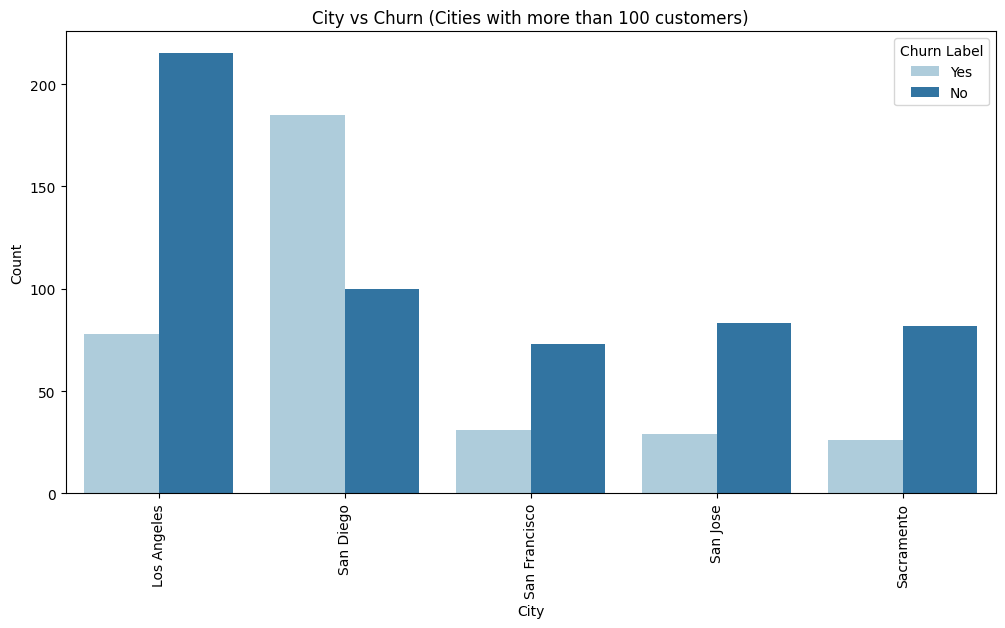

In [15]:
#city vs Churn
#set the minimum number of customers a city must have
min_customers = 100  # You can adjust this number

# Group by city and filter cities with customers above the threshold
city_counts = data['City'].value_counts()
valid_cities = city_counts[city_counts >= min_customers].index

# Filter the data for cities with customer counts above the threshold
filtered_data = data[data['City'].isin(valid_cities)]

# Plot City vs Churn for filtered cities
plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_data, x='City', hue='Churn Label', palette='Paired')
plt.title(f'City vs Churn (Cities with more than {min_customers} customers)')
plt.xticks(rotation=90)
plt.xlabel('City')
plt.ylabel('Count')
plt.show()


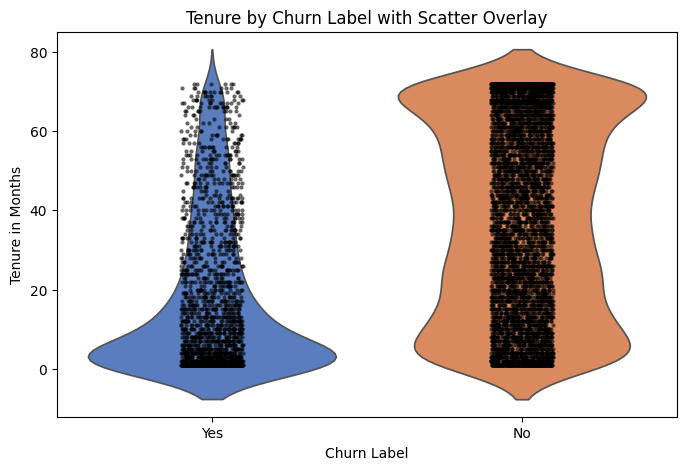

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
from matplotlib.sankey import Sankey
import plotly.graph_objects as go

# Load the data
data = pd.read_csv(r'C:\Users\walte\OneDrive\Documents\Work\Customer churn\telco.csv')

# Relationship between tenure and churn
plt.figure(figsize=(8, 5))

# Create the violin plot with hue
sns.violinplot(data=data, x='Churn Label', y='Tenure in Months', hue='Churn Label', 
                palette='muted', inner=None, legend=False)

# Overlay the scatter plot
sns.stripplot(data=data, x='Churn Label', y='Tenure in Months', color='k', alpha=0.6, size=3)

plt.title('Tenure by Churn Label with Scatter Overlay')
plt.xlabel('Churn Label')
plt.ylabel('Tenure in Months')
plt.show()

Churn Label      No   Yes
Phone Service            
No              512   170
Yes            4662  1699


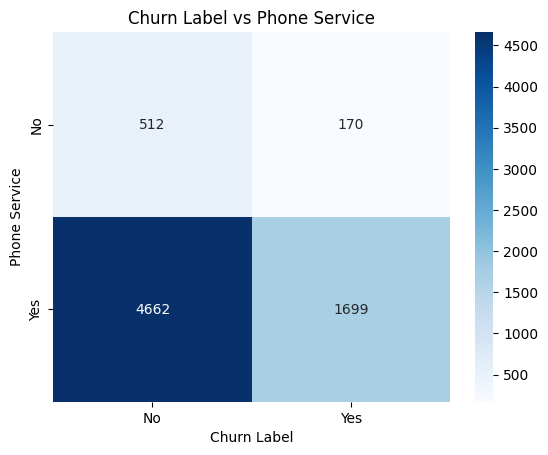

In [8]:
# Create a crosstab of Phone Service and Churn Label
crosstab_phone_churn = pd.crosstab(data['Phone Service'], data['Churn Label'])

# Print the crosstab
print(crosstab_phone_churn)

# Visualize the crosstab
sns.heatmap(crosstab_phone_churn, annot=True, fmt='d', cmap='Blues')
plt.title('Churn Label vs Phone Service')
plt.ylabel('Phone Service')
plt.xlabel('Churn Label')
plt.show()

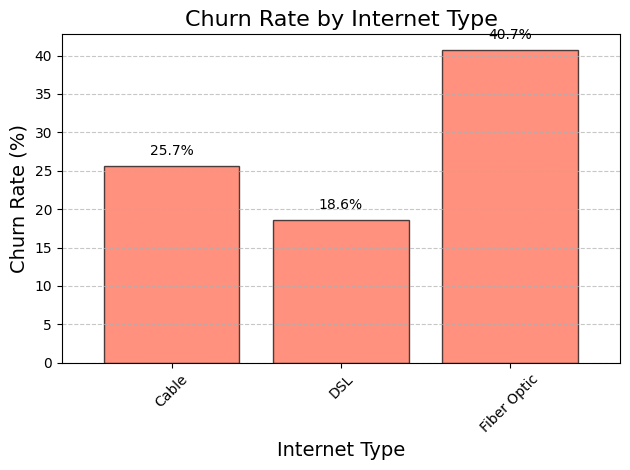

In [10]:
# Calculate churn rates by internet type

churn_rates = data.groupby('Internet Type')['Churn Label'].value_counts(normalize=True).unstack() * 100

# Rename the columns for better understanding
churn_rates.columns = ['Not Churn', 'Churn']

# Create a bar plot for churn rates
churn_rates['Churn'].plot(kind='bar', color='#FF6347', edgecolor='black', alpha=0.7, width=0.8)

# Add labels and title
plt.title('Churn Rate by Internet Type', fontsize=16)
plt.xlabel('Internet Type', fontsize=14)
plt.ylabel('Churn Rate (%)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the percentage on top of the bars
for index, value in enumerate(churn_rates['Churn']):
    plt.text(index, value + 1, f'{value:.1f}%', ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()

Machine Learning:
Preprocessing:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
from matplotlib.sankey import Sankey
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the data
df = pd.read_csv(r'C:\Users\walte\OneDrive\Documents\Work\Customer churn\telco.csv')

# Fill missing values in relevant columns
df[['Churn Category', 'Churn Reason']] = df[['Churn Category', 'Churn Reason']].fillna('not churned')

# Convert 'Zip Code' to string (categorical)
df['Zip Code'] = df['Zip Code'].astype(str)

# Create a tenure feature in years (optional, you can keep the original 'Tenure in Months')
df['Tenure in Years'] = pd.cut(df['Tenure in Months'], bins=range(0, 73, 12), labels=range(1, 7)).astype(int)

# Target variable
target = 'Churn Label'

# Exclude non-predictive features
var_not_used = ['Customer ID', 'Country', 'State', 'Latitude', 'Longitude', 'Quarter', 
                'Customer Status', 'Churn Score', 'CLTV', 'Churn Category', 'Churn Reason', 
                'Payment Method']  # Exclude Payment Method here

# Define features (all columns except the target and those to exclude)
features = [col for col in df.columns if col not in [target] + var_not_used]

# Separate numeric and categorical features
numeric_features = df[features].select_dtypes(include=['number']).columns.tolist()
categoric_features = df[features].select_dtypes(exclude=['number']).columns.tolist()

# Define ordinal and nominal features
ordinal = ['Referred a Friend', 'Phone Service', 'Multiple Lines', 'Internet Service', 
           'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 
           'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data']

nominal = ['Gender', 'Under 30', 'Senior Citizen', 'Married', 'Dependents', 'Offer', 
           'Internet Type', 'Contract', 'Paperless Billing']

# Step 2: Preprocessing Pipelines
ordinal_pipe = Pipeline(steps=[
    ('ordinal_encoder', OrdinalEncoder(categories=[['No', 'Yes']] * len(ordinal))),
    ('minmax_scaler', MinMaxScaler())
])
nominal_pipe = Pipeline(steps=[
    ('onehot_encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))  # Added handle_unknown
])
numeric_pipe = Pipeline(steps=[
    ('power_transformer', PowerTransformer(method='yeo-johnson')),
    ('minmax_scaler', MinMaxScaler())
])

# Combine all preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', ordinal_pipe, ordinal),
        ('nominal', nominal_pipe, nominal),
        ('numeric', numeric_pipe, numeric_features)
    ]
)

# Step 3: Split data into training and testing sets
X = df[features]
y = df[target].map({'Yes': 1, 'No': 0})  # Map target to binary (1 for churn, 0 for no churn)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Model Selection and Training
# Using RandomForestClassifier as the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9475


In [2]:
# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

              precision    recall  f1-score   support

           0       0.94      1.00      0.96      1009
           1       0.99      0.83      0.90       400

    accuracy                           0.95      1409
   macro avg       0.96      0.91      0.93      1409
weighted avg       0.95      0.95      0.95      1409

Confusion Matrix:
[[1004    5]
 [  69  331]]


              Feature  Importance
41  Contract_Two Year    0.493465
32      Offer_Offer B    0.046730
40  Contract_One Year    0.041334
35      Offer_Offer E    0.036432
26     Unlimited Data    0.035041
36          Offer_nan    0.030149
39  Internet Type_nan    0.026094
31     Dependents_Yes    0.025482
28       Under 30_Yes    0.025386
23       Streaming TV    0.022707


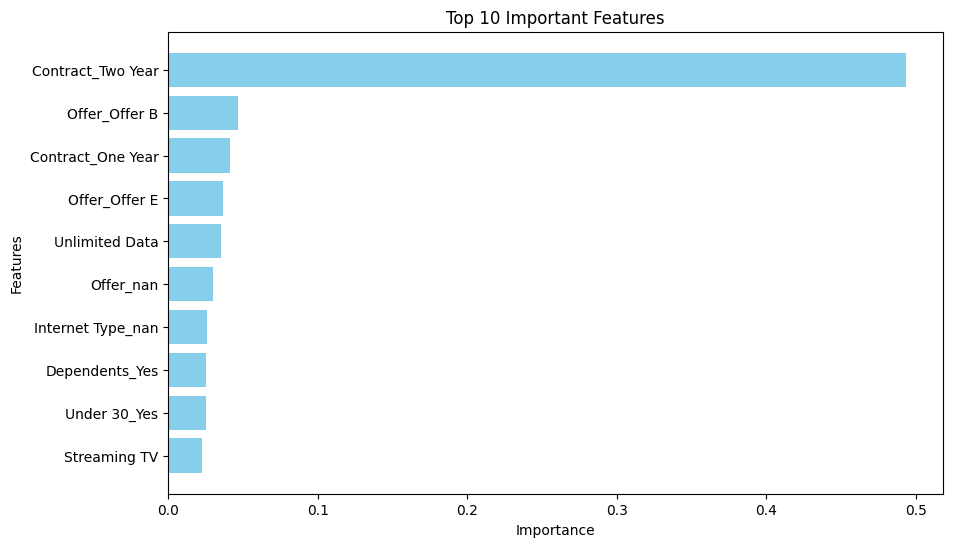

In [3]:
if isinstance(model.named_steps['classifier'], RandomForestClassifier):
    importances = model.named_steps['classifier'].feature_importances_

    # Get feature names from the preprocessor
    one_hot_features = model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot_encoder'].get_feature_names_out(input_features=nominal)
    feature_names = numeric_features + ordinal + list(one_hot_features)
    
    # Create a DataFrame to visualize the feature importances
    feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

    print(feature_importances.head(10))

     # Optional: Plot feature importances
    plt.figure(figsize=(10,6))
    plt.barh(feature_importances['Feature'][:10], feature_importances['Importance'][:10], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Top 10 Important Features')
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.show()

Findings:

In my machine learning project focused on predicting customer churn, I achieved an impressive accuracy of 94.75%. This means that my model was able to correctly predict churn (or lack of churn) for nearly 95% of the customers in the dataset. With a precision of 0.99 for predicting churn, the model is highly accurate in identifying customers who are likely to churn, although the recall of 0.83 suggests that there are still some churn cases that it missed.

The confusion matrix showed that out of 1009 non-churning customers, the model correctly predicted 1004 of them, while only 5 were mistakenly classified as churners. On the other hand, out of 400 actual churners, the model correctly identified 331, with 69 false negatives. This highlights that while the model is highly accurate overall, there is room for improvement in identifying all churners.

When looking at the feature importances, it’s clear that the customer's contract type plays a significant role in predicting churn. Specifically, a Two-Year Contract stands out as the most important feature, with nearly 50% importance, meaning that customers on longer contracts are less likely to churn. Other notable features include specific offers and whether a customer has Unlimited Data, which also influence churn predictions.

Overall, this project has provided valuable insights into which factors influence customer churn and demonstrates the model’s strength in making accurate predictions